# Описание проекта


Программа предназначена для обработки параллельного корпуса (исходный язык - английский, целевой язык - русский).
Используя различные встроенные и пользовательские фильтры OpusFilter программа отфильтрует некачественные сегменты корпуса.

Для работы проекта необходимо в корне подключенного google диска создать папку `paralell-corpora-proc` внутри которой расположена директория `code` с следующими содержимым:
- Директория `configs` - конфигурационные файлы в формате yaml.
- Директория `custom_filters` - пользовательские фильтры.
- Директория `filtered_dataset` - в этой директории создаются директории с именем шага согласно конфигурационному YAML файлу. Внутри каждой будет храниться два файла параллельного корпуса.
- Директория `scripts` - вспомогательные скрипты для работы проекта.
- Директория `source_dataset` - параллельный корпус для обработки.





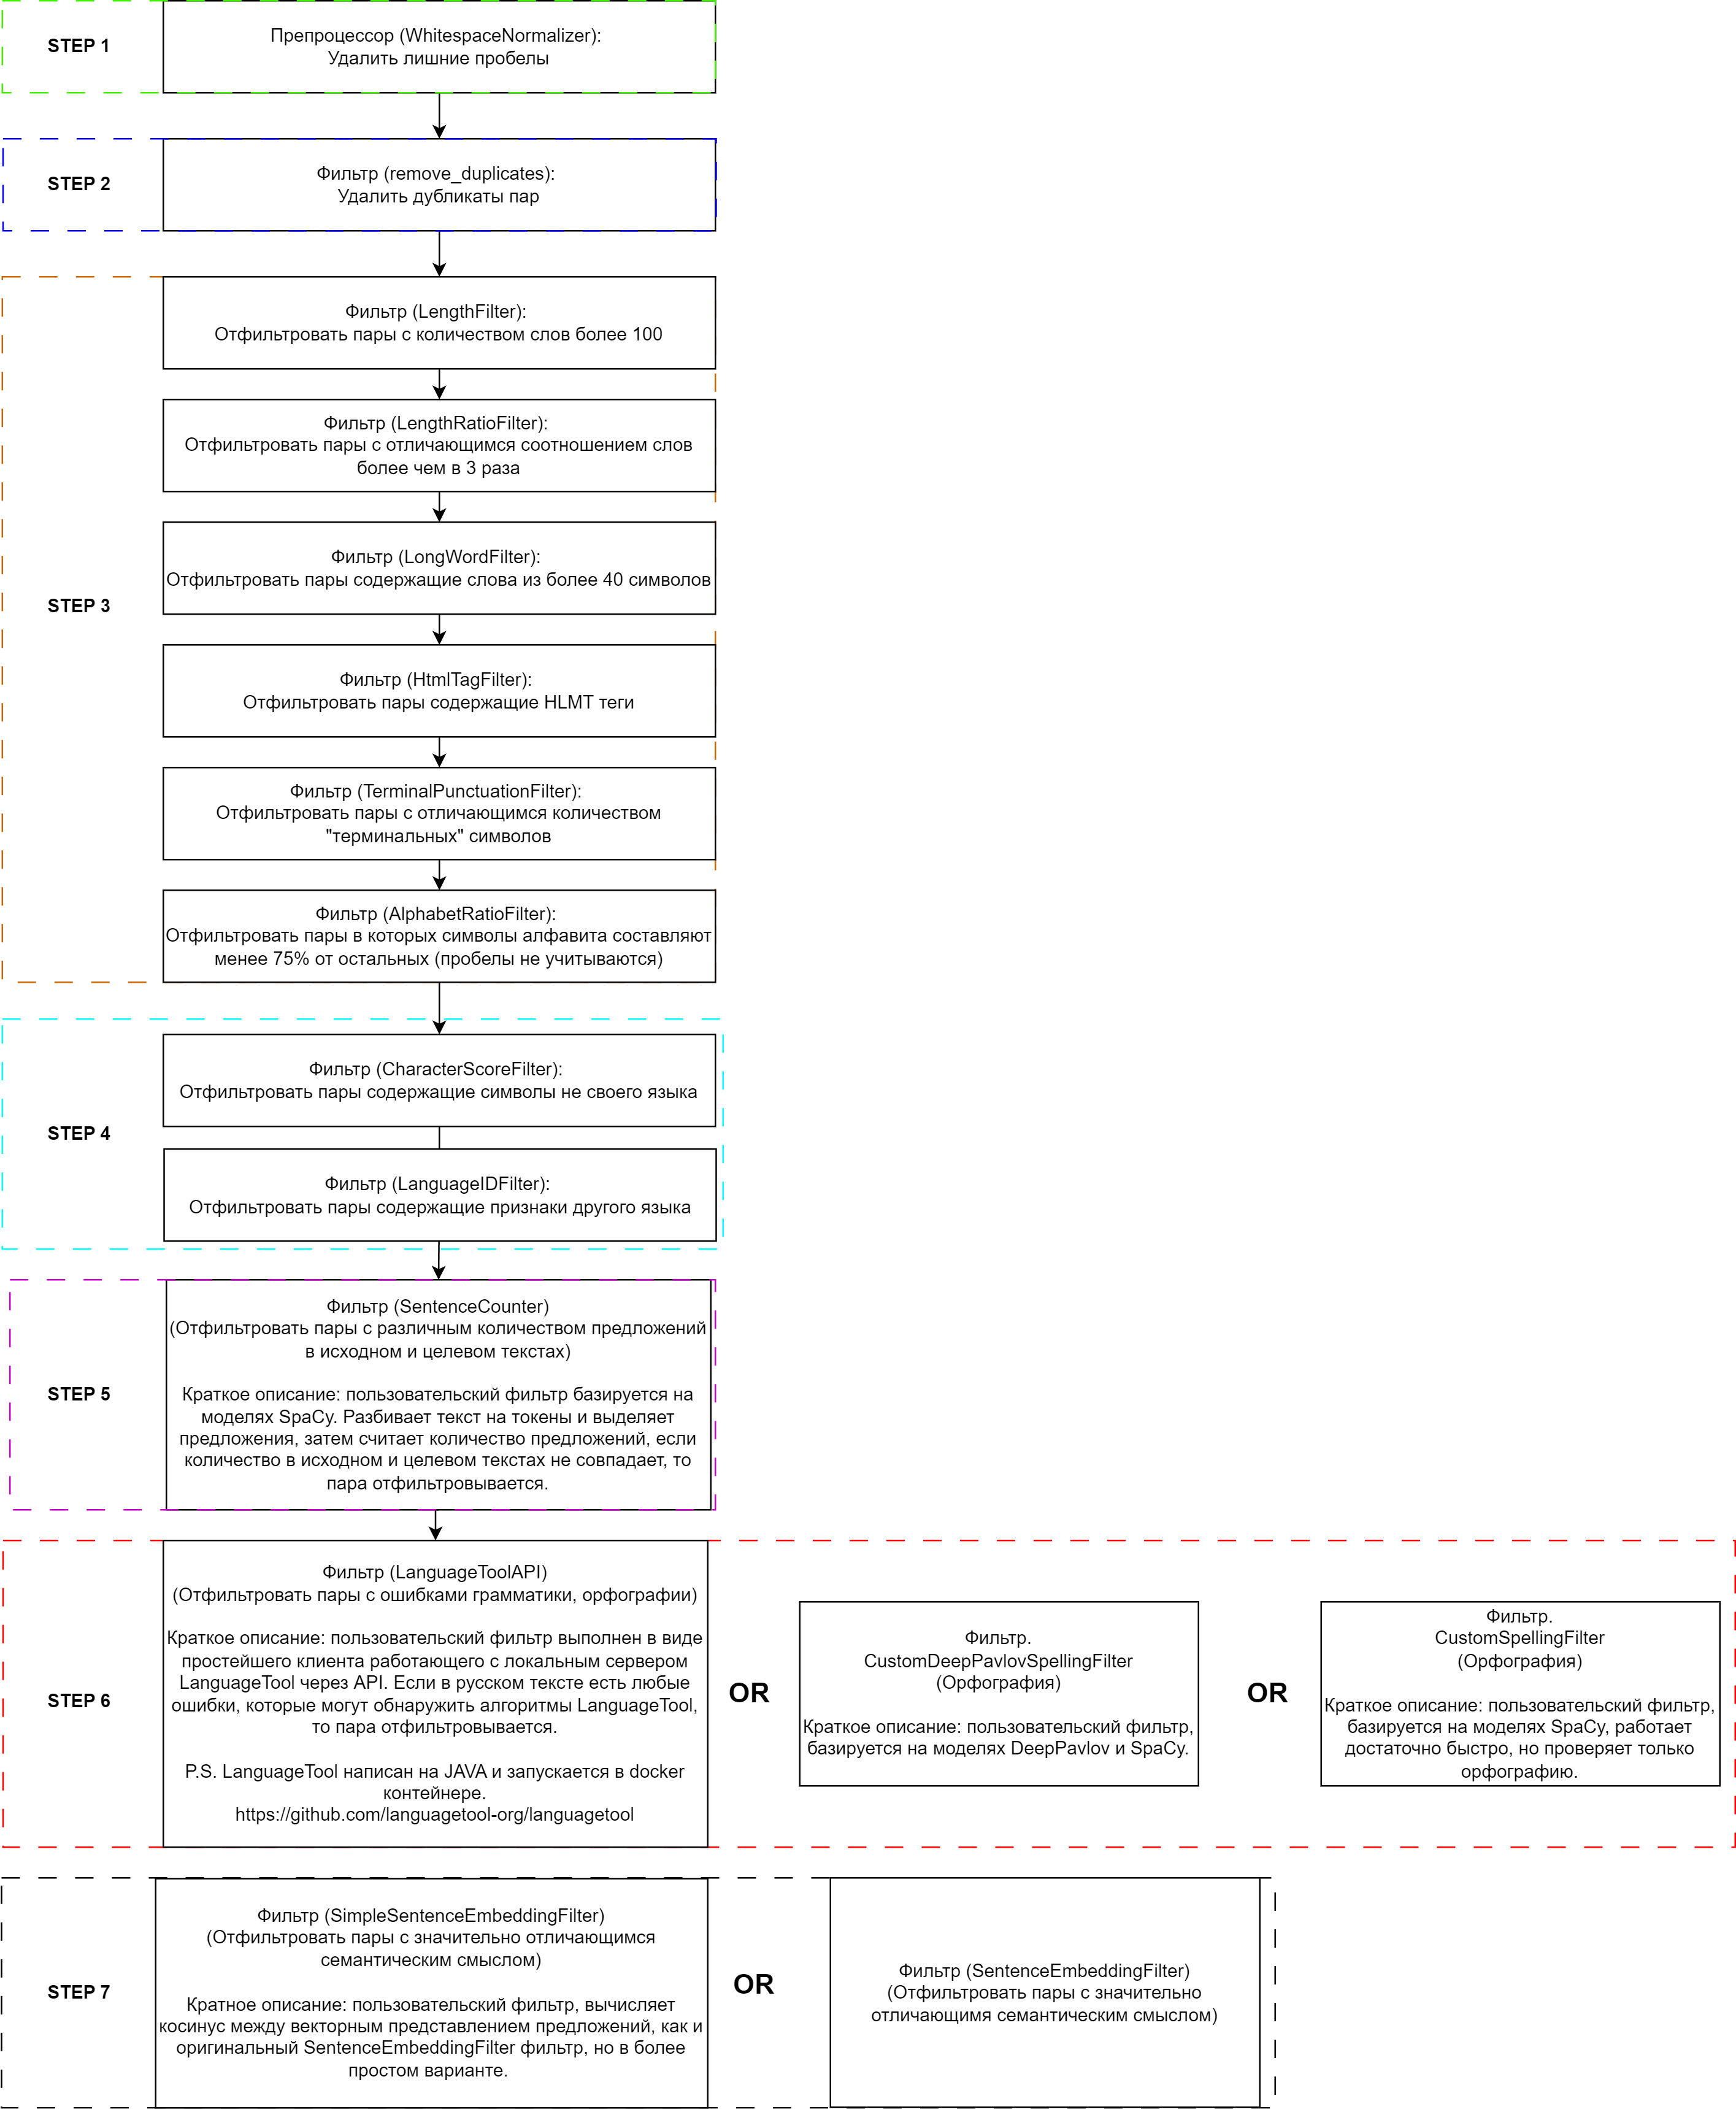

Рисунок 1 - Схема работы фильтра

# Настроенный pipeline работы OpusFilter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Установка необходимых пакетов и загрузка моделей

In [ ]:
!pip install opusfilter[all]

In [ ]:
!python -m laserembeddings download-models

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U 'spacy[cuda12x]'
!python -m spacy download xx_sent_ud_sm
!python -m spacy download ru_core_news_sm

## Добавление переменных среды и импорт вспомогательных функций

In [ ]:
import os
os.environ['PYTHONPATH'] += ":/content/drive/MyDrive/paralell-corpora-proc/code/custom_filters"
!echo $PYTHONPATH

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/paralell-corpora-proc/code/scripts")

In [ ]:
from step_stat import print_stat

## ШАГ 1. Препроцессор. Удалить лишние пробелы

In [ ]:
!opusfilter --overwrite --single 1 drive/MyDrive/paralell-corpora-proc/code/configs/config_main.yaml

## ШАГ 2. Отфильтровать дубликаты пар

In [ ]:
!opusfilter --overwrite --single 2 drive/MyDrive/paralell-corpora-proc/code/configs/config_main.yaml

In [ ]:
print_stat('/content/drive/MyDrive/paralell-corpora-proc/code/source_dataset/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_1/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_2/ru')

## ШАГ 3. Отфильтровать:


*   пары в строках которых больше 100 слов
*   пары у которых соотношение слов более чем в 3 раза отличается
*   пары с словами более 40 символов
*   пары содержащие HTML теги
*   пары в которых отличается количество 'терминальных' символов в исходном и конечном текстах
*   пары в которых количество буквенных символов составляет менее 75%



In [ ]:
!opusfilter --overwrite --single 3 drive/MyDrive/paralell-corpora-proc/code/configs/config_main.yaml

In [ ]:
print_stat('/content/drive/MyDrive/paralell-corpora-proc/code/source_dataset/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_2/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_3/ru')

## ШАГ 4. Отфильтровать:


*   пары в которых обнаружены символы не соответствующие заданному языку
*   пары в по признакам языка



In [ ]:
!opusfilter --overwrite --single 4 drive/MyDrive/paralell-corpora-proc/code/configs/config_main.yaml

In [ ]:
print_stat('/content/drive/MyDrive/paralell-corpora-proc/code/source_dataset/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_3/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_4/ru')

## ШАГ 5. Отфильтровать пары с различным количеством предложений в исходном и целевом текстах

Краткое описание: пользовательский фильтр базируется на моделях SpaCy. Разбивает текст на токены и выделяет предложения, затем считает количество предложений, если количество в исходном и целевом текстах не совпадает, то пара отфильтровывается.

In [ ]:
!opusfilter --overwrite --single 5 drive/MyDrive/paralell-corpora-proc/code/configs/config_main.yaml

In [ ]:
print_stat('/content/drive/MyDrive/paralell-corpora-proc/code/source_dataset/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_4/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_5/ru')

## ШАГ 6 (вариант 1). Отфильтровать пары с ошибками грамматики, орфографии. LanguageToolAPI

Краткое описание: пользовательский фильтр выполнен в виде простейшего клиента работающего с локальным сервером LanguageTool через API. Если в русском тексте есть любые ошибки, которые могут обнаружить алгоритмы LanguageTool, то пара отфильтровывается.

P.S. LanguageTool написан на JAVA и запускается в docker контейнере.
https://github.com/languagetool-org/languagetool

Ссылка на репозиторий с автором docker контейнера: https://github.com/Erikvl87/docker-languagetool

По понятным причинам данный шаг невозможно просто запустить в colab. Можно либо пробросить внешний адрес к своему docker контейнеру с LanguageTool в конфигурационном yaml (/content/drive/MyDrive/paralell-corpora-proc/workdir/config/config_main.yaml) либо выполнить этот шаг на своем компьютере (в local runtime например) в зоне localhost с запушенным docker контейнером c LanguageTool на порту 8010.

In [ ]:
!opusfilter --overwrite --single 6 drive/MyDrive/paralell-corpora-proc/code/configs/config_main.yaml

In [ ]:
print_stat('/content/drive/MyDrive/paralell-corpora-proc/code/source_dataset/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_5/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_6/ru')

** !!! Если нет возможности запустить в docker LanguageTool, то этот шаг можно пропустить, раскомментировав и выполнив следующий cell. Он просто скопирует с шага 5 результатыв папку с шагом 6. !!!**






In [ ]:
#!cp /content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_5/en /content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_6/en
#!cp /content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_5/ru /content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_6/ru

## ШАГ 6 (вариант 2). Отфильтровать пары с ошибками орфографии. DeepPavlov + SpaCy

Краткое описание: пользовательский фильтр проверяет наличие ошибок основываясь на результатах проверки DeepPavlov, SpaCy используется для токенизации.

In [ ]:
!pip install -q deeppavlov

In [ ]:
!python -m deeppavlov install brillmoore_wikitypos_en

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [ ]:
!opusfilter --overwrite --single 6 drive/MyDrive/paralell-corpora-proc/code/configs/config_main_step_6_option_2.yaml

In [ ]:
print_stat('/content/drive/MyDrive/paralell-corpora-proc/code/source_dataset/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_5/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_6/ru')

## ШАГ 7. Отфильтровать пары с значительно отличающимя семантическим смыслом.

Кратное описание: пользовательский фильтр, вычисляет косинус между векторным представлением предложений, как и оригинальный SentenceEmbeddingFilter фильтр, но в более простом варианте.

In [ ]:
!opusfilter --overwrite --single 7 drive/MyDrive/paralell-corpora-proc/code/configs/config_main.yaml

In [ ]:
print_stat('/content/drive/MyDrive/paralell-corpora-proc/code/source_dataset/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_6/ru', '/content/drive/MyDrive/paralell-corpora-proc/code/filtered_dataset/step_7_final/filtered.ru')